# Airbnbing in Florence

The scope of this project is to understand how much AirBNB homes are earning in certain time frames and areas, in the City of Florence, Tuscany. The project follows the guidelines CRISP-DM.

We want to investigate how we could invest capital into a flat of small-to-medium size (studio to 2 bedrooms) to rent for turists. To do so, we want to try to answer the following points:
  * Understand how airbnb businesses generally go in Florence: which areas of Florence are more popular, bringing highest occupancy, highlighting which ones are more consolidated over time, and which are the areas where new listings are appearing
  * Relate the listing offer to our business goal: listings are of any types, whereas we are interested in exploring small-to-medium-sized flats
  * Investigate the caracteristics of flats in relation to returns (how many guests can accept, utilities etc.) for the consolidated activities


In [70]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta



from shapely.geometry import Point
import geoplot
from geopy.distance import geodesic
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 881D-75E1

 Directory of C:\dev\airbnb_florence

18/08/2019  20:04    <DIR>          .
18/08/2019  20:04    <DIR>          ..
10/08/2019  19:01             1,331 .gitignore
11/08/2019  10:44    <DIR>          .ipynb_checkpoints
13/08/2019  21:12    <DIR>          data
18/08/2019  20:04         1,164,032 florence_listings.ipynb
11/08/2019  12:00             1,303 README.md
16/08/2019  08:47             5,142 requirements.yml
               4 File(s)      1,171,808 bytes
               4 Dir(s)  13,107,257,344 bytes free


In [3]:
PATH = os.getcwd()
fn_listings = os.path.join(PATH, 'data', 'listings.csv')
fn_districts = os.path.join(PATH, 'data', 'neighbourhoods.geojson')

In [4]:
df_lst = pd.read_csv(fn_listings, parse_dates=['host_since','first_review','last_review'])
df_dst = gpd.read_file(fn_districts)

C:\Users\Claudio\AppData\Local\conda\conda\envs\airbnb_florence\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (43,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_dst

,neighbourhood,neighbourhood_group,geometry
0,Rifredi,None,"(POLYGON ((11.15421 43.786381, 11.153517 43.78..."
1,Gavinana Galluzzo,None,"(POLYGON ((11.231188 43.759284, 11.23121 43.75..."
2,Campo di Marte,None,"(POLYGON ((11.270991 43.764896, 11.271159 43.7..."
3,Isolotto Legnaia,None,"(POLYGON ((11.20787 43.749145, 11.207715 43.74..."
4,Centro Storico,None,"(POLYGON ((11.231188 43.759284, 11.231573 43.7..."


In [6]:
# listings. name and host_name are  reduntant as indxing can be done per id and host_id.
df_lst.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,24469,https://www.airbnb.com/rooms/24469,20190622031149,2019-06-22,Fortezza/City Centre Modern Apt 2+2,"Apartment, perfect for 2 people, wide, bright ...",Located on the first floor of a 19th century t...,"Apartment, perfect for 2 people, wide, bright ...",none,In 10/15 minutes walking or with only one stop...,...,t,f,moderate_new,f,f,5,5,0,0,NaN
1,24470,https://www.airbnb.com/rooms/24470,20190622031149,2019-06-22,Fortezza/City Centre Modern Apt 2+1,"Apartment, perfect for 2 people, can accommoda...",Located on the first floor of a 19th century t...,"Apartment, perfect for 2 people, can accommoda...",none,In 10/15 minutes walking you will reach the hi...,...,t,f,moderate_new,f,f,5,5,0,0,0.03
2,24471,https://www.airbnb.com/rooms/24471,20190622031149,2019-06-22,Fortezza/City Centre Modern Apt 4+2,"Perfect, big apartment for families or groups ...",Located on the first floor of a 19th century t...,"Perfect, big apartment for families or groups ...",none,In 10/15 minutes walking you will reach the hi...,...,t,f,moderate_new,f,f,5,5,0,0,NaN
3,24472,https://www.airbnb.com/rooms/24472,20190622031149,2019-06-22,Fortezza/City Centre Modern Apt 4+2,"Santa Maria Novella, perfect apartment for fam...",Located on the first floor of a 19th century t...,"Santa Maria Novella, perfect apartment for fam...",none,In 10/15 minutes walking or with only one stop...,...,t,f,moderate_new,f,f,5,5,0,0,0.02
4,24807,https://www.airbnb.com/rooms/24807,20190622031149,2019-06-22,Beautiful Apartment Florence & WIFI,"CLEANLINESS, COMFORT and QUIETNESS!! Our stren...",It's not a case if we have some 330 five star ...,"CLEANLINESS, COMFORT and QUIETNESS!! Our stren...",none,NaN,...,t,f,moderate_new,f,f,1,1,0,0,3.10


In [7]:
df_lst.shape

(12022, 106)

### Explore Data

We want to see all the data we gathered. Eventually, for the scope of this excercise we want to discard/add some features

In [8]:
list(df_lst.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [9]:
# Here we delete most of the columns, partially because of not relevant information 
# (e.g. url, as we don't want to run any web-scraping) and so we want to
# simplify the dataset. This is due to the exploratory ambition

cols=[
    'id',
#     'listing_url',
#     'scrape_id',
#     'last_scraped',
#     'name',
#     'summary',
#     'space',
#     'description',
#     'experiences_offered',
#     'neighborhood_overview',
#     'notes',
#     'transit',
#     'access',
#     'interaction',
#     'house_rules',
#     'thumbnail_url',
#     'medium_url',
#     'picture_url',
#     'xl_picture_url',
    'host_id',
#     'host_url',
#     'host_name',
    'host_since',
#     'host_location',
#     'host_about',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'host_is_superhost',
#     'host_thumbnail_url',
#     'host_picture_url',
#     'host_neighbourhood',
    'host_listings_count',
#     'host_total_listings_count',
#     'host_verifications',
#     'host_has_profile_pic',
#     'host_identity_verified',
#     'street',
    'neighbourhood',
    'neighbourhood_cleansed',
#     'neighbourhood_group_cleansed',
#     'city',
#     'state',
#     'zipcode',
#     'market',
#     'smart_location',
#     'country_code',
#     'country',
    'latitude',
    'longitude',
#     'is_location_exact',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'bed_type',
    'amenities',
    'square_feet',
    'price',
#     'weekly_price',
#     'monthly_price',
#     'security_deposit',
#     'cleaning_fee',
    'guests_included',
    'extra_people',
    'minimum_nights',
#     'maximum_nights',
#     'minimum_minimum_nights',
#     'maximum_minimum_nights',
#     'minimum_maximum_nights',
#     'maximum_maximum_nights',
#     'minimum_nights_avg_ntm',
#     'maximum_nights_avg_ntm',
#     'calendar_updated',
#     'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
#     'calendar_last_scraped',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'first_review',
    'last_review',
    'review_scores_rating',
#     'review_scores_accuracy',
#     'review_scores_cleanliness',
#     'review_scores_checkin',
#     'review_scores_communication',
#     'review_scores_location',
#     'review_scores_value',
#     'requires_license',
#     'license',
#     'jurisdiction_names',
    'instant_bookable',
#     'is_business_travel_ready',
    'cancellation_policy',
#     'require_guest_profile_picture',
#     'require_guest_phone_verification',
#     'calculated_host_listings_count',
#     'calculated_host_listings_count_entire_homes',
#     'calculated_host_listings_count_private_rooms',
#     'calculated_host_listings_count_shared_rooms',
    'reviews_per_month'
]

In [10]:
df_lst = df_lst[cols]
df_lst.shape

(12022, 37)

## Data Processing

In [11]:
# let's see the stats.
# neighbourhood_group is all nan, as there is no grouping for Florence. Also look like some prices are at 0.
df_lst.describe()

,id,host_id,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,guests_included,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,reviews_per_month
count,1.202200e+04,1.202200e+04,0.0,11998.000000,12022.000000,12022.000000,12022.000000,12015.000000,12012.000000,11999.000000,...,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,10272.000000,10349.000000
mean,1.799306e+07,6.589200e+07,NaN,30.347558,43.773871,11.253617,3.832391,1.310612,1.463287,2.344529,...,1.803111,2.977791,10.466395,26.091915,43.350108,200.680087,48.030611,15.893445,93.702005,2.049765
std,1.085978e+07,7.523406e+07,NaN,122.926828,0.009772,0.016564,2.000567,0.683907,0.898514,1.670910,...,1.254920,18.527526,9.438975,19.271003,28.850653,122.536516,74.106464,21.555396,7.201178,1.956661
min,2.446900e+04,1.565100e+04,NaN,0.000000,43.726130,11.159010,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.010000
25%,7.795951e+06,7.147408e+06,NaN,1.000000,43.768540,11.245380,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,9.000000,19.000000,86.000000,2.000000,1.000000,91.000000,0.470000
50%,1.868842e+07,3.077204e+07,NaN,3.000000,43.772285,11.254120,4.000000,1.000000,1.000000,2.000000,...,1.000000,2.000000,8.000000,25.000000,45.000000,226.500000,15.000000,6.000000,96.000000,1.440000
75%,2.702809e+07,1.083819e+08,NaN,10.000000,43.778060,11.261977,5.000000,1.500000,2.000000,3.000000,...,2.000000,3.000000,18.000000,43.000000,68.000000,314.000000,62.000000,24.000000,98.000000,3.110000
max,3.594108e+07,2.702475e+08,NaN,1459.000000,43.831740,11.331010,16.000000,12.000000,13.000000,23.000000,...,16.000000,1120.000000,30.000000,60.000000,90.000000,365.000000,719.000000,151.000000,100.000000,14.640000


We want to check missing data throughout the dataset. Let's see rows and columns which might create issue during data processing.

In [12]:
nans = pd.concat([df_lst.isna().sum(),df_lst.dtypes],axis=1)
nans = nans.rename(columns={0:'nans',1:'dtypes'})
nans

,nans,dtypes
id,0,int64
host_id,0,int64
host_since,24,datetime64[ns]
host_response_time,1205,object
host_response_rate,1205,object
host_acceptance_rate,12022,float64
host_is_superhost,24,object
host_listings_count,24,float64
neighbourhood,0,object
neighbourhood_cleansed,0,object


### Data: Observations

We identify three degree of missing data: **minor** (<5%), **low** (~10%), or **high** (>90%). Moreover, there is something weird with the **dtypes**.

**High percentage of nans**

Apparently, little `square_feet` and `host_acceptance_rate` data is available. We should drop the columns as they do not provide great insights.

**Minor percentage of nans**

Let's cull those records which bring no information about the `rooms`, so also `bathrooms`, `bedrooms` and `beds`, as we are tlking of just a few records, so we are not going to compromise our dataset.

**dtypes**

Finally, `price` and `extra_people` are fees, but their dtypes are objects. This is due to currency `$` and comma `,` chars embedded and recorded as strings. Let's change those to floats, keeping in mind that they're USD.

We will later see the low percentage of nan values.

In [48]:
# drop low-information columns
df_lst_ = df_lst.drop(columns=['host_acceptance_rate','square_feet'],axis=1).copy()

# drop few rows with nan data
m1 = (df_lst_['beds'].isna())
m2 = (df_lst_['bathrooms'].isna()) 
m3 = (df_lst_['bedrooms'].isna())
m4 = (df_lst_['host_since'].isna())
m5 = (df_lst_['host_is_superhost'].isna())
m6 = (df_lst_['host_listings_count'].isna())
mask = m1 | m2 | m3 | m4 | m5 | m6
df_lst_ = df_lst_[~mask].copy()

# convert price to float (usd)
df_lst_['price']=df_lst['price'].replace('[\$,]','',regex=True).astype(float) #apply(lambda x:float(x.split('$')[-1]))
df_lst_['extra_people']=df_lst['extra_people'].replace('[\$,]','',regex=True).astype(float) #apply(lambda x:float(x.split('$')[-1]))

In [49]:
nans2 = pd.concat([df_lst_.isna().sum(),df_lst_.dtypes],axis=1)
nans2 = nans2.rename(columns={0:'nans',1:'dtypes'})
nans2

,nans,dtypes
id,0,int64
host_id,0,int64
host_since,0,datetime64[ns]
host_response_time,1179,object
host_response_rate,1179,object
host_is_superhost,0,object
host_listings_count,0,float64
neighbourhood,0,object
neighbourhood_cleansed,0,object
latitude,0,float64


**Low percentage of nans**

`host_response_time` and `host_response_rate` have some nans. This might be due to the fact that no bookings have been done for that listing. This should let us ask if we want to consider or not those (new listings? oldl istings fogotten by the host?). Let's drop them since we are talking about 10% of the dataset.

Let's see if we drop them, what happens

In [50]:
mask = df_lst_['host_response_time'].isna()
df_lst_ = df_lst_[~mask]
df_lst_.isna().sum()

id                           0
host_id                      0
host_since                   0
host_response_time           0
host_response_rate           0
host_is_superhost            0
host_listings_count          0
neighbourhood                0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
amenities                    0
price                        0
guests_included              0
extra_people                 0
minimum_nights               0
availability_30              0
availability_60              0
availability_90              0
availability_365             0
number_of_reviews            0
number_of_reviews_ltm        0
first_review              1230
last_review               1230
review_scores_rating      1288
instant_

First and last reviews nans drop by ~20%. This might suggest inactive profiles. We should definitely investigate further, but let's assume they are inactive and keep these away in another dataset, as we are interested in real businesses.

We could accept the rest of missing values as they are missing a review, or a review score if they have no reviews. So we drop the missing scores in case they do have a review in the records. This values look weird as we cannot really say why a review brings no score.

In [51]:
mask2 = (df_lst_['review_scores_rating'].isna() & ~df_lst_['first_review'].isna())
df_lst_ = df_lst_[~mask2]
df_lst_.isna().sum()

id                           0
host_id                      0
host_since                   0
host_response_time           0
host_response_rate           0
host_is_superhost            0
host_listings_count          0
neighbourhood                0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
amenities                    0
price                        0
guests_included              0
extra_people                 0
minimum_nights               0
availability_30              0
availability_60              0
availability_90              0
availability_365             0
number_of_reviews            0
number_of_reviews_ltm        0
first_review              1230
last_review               1230
review_scores_rating      1230
instant_

Save the dataframe somewhere

In [52]:
# save to kernel
df_kernel1 = df_lst_.copy()
df_kernel1.shape

(10726, 35)

### Price Values

A maximum price of 4000`$` per night seems pretty out-of-the-standard. By the way, this does not match with the maximum from the stats, which shows 5000`$`: this might suggest that there might be a very expensive listing with no or faulty letting records.

As we are interested of purchasing a flat of medium size, Let's see how many items are above 500`$` per night. This is due to prices given by high-end hotels (e.g. Lungarno Hotel, St. Regis Hotel) as well as to the price distribution shown on the histogram below. We want also to eliminate prices outliers (e.g. 0 euro per night)

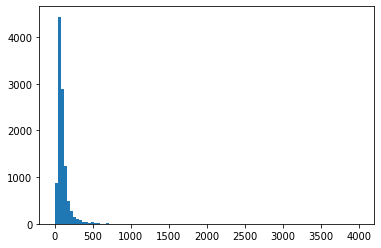

In [54]:
plt.hist(df_lst_['price'].values,bins=100);

In [57]:
# only two records have price == 0
df_lst_[df_lst_['price'] == 0]['id'].count()

2

In [58]:
df_lst_[df_lst_['price'] > 500]['id'].count()

88

Let's remove from the df_lst the records with price per night of 0, and  and dropping unecessary columns. We want also to exclude particularly expensive flats because they are out of our business scope.

In [59]:
df_lst_ = df_lst_[df_lst_['price'] != 0]
df_lst_ = df_lst_[df_lst_['price'] <= 500]
df_lst_.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,neighbourhood,neighbourhood_cleansed,latitude,...,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,24469,99178,2010-03-26,within a few hours,100%,f,5.0,Centro Storico,Centro Storico,43.78308,...,70,345,0,0,NaT,NaT,NaN,t,moderate_new,NaN
1,24470,99178,2010-03-26,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78287,...,78,350,3,1,2010-09-22,2019-04-21,93.0,t,moderate_new,0.03
2,24471,99178,2010-03-26,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78292,...,80,355,0,0,NaT,NaT,NaN,t,moderate_new,NaN
3,24472,99178,2010-03-26,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78150,...,67,342,2,0,2011-06-28,2012-04-11,60.0,t,moderate_new,0.02
4,24807,68490,2010-01-07,within an hour,100%,f,2.0,Campo di Marte,Campo di Marte,43.77813,...,36,152,344,20,2010-05-11,2019-05-21,96.0,t,moderate_new,3.10


In [60]:
df_lst_.shape

(10636, 35)

Mean: 96.0
Mode: 60.0


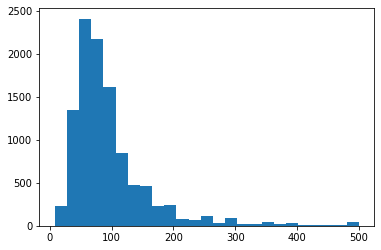

In [61]:
print("Mean: {}\nMode: {}".format(round(df_lst_['price'].mean()),df_lst_['price'].mode()[0]))
plt.hist(df_lst_['price'],bins=25);

## Areas - part 1

Understand how airbnb businesses generally go in Florence. Assuming that the occupancy and the number of reviews play a role into how likely people are to book a stay, we want to understand:
  * Which areas of Florence are more popular, bringing highest occupancy.
  * Which areas are more consolidated over time
  * Which are the areas where new listings are appearing

Firstly, we want to look at the areas and how they are classified throughout the city, make sure that the data is consistant, and eventually amend it. Then, we will look at prices, occupancy and number of reviews for each area.

In [62]:
# build a GeoDataFrame
lats,lons = df_lst_['latitude'].values, df_lst_['longitude'].values
pts = [Point(lon,lat) for lat,lon in zip(lats,lons)]
gdf_lst = gpd.GeoDataFrame(data=df_lst_,geometry=pts)
print(gdf_lst.shape)
gdf_lst.head()

(10636, 36)


,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,neighbourhood,neighbourhood_cleansed,latitude,...,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,geometry
0,24469,99178,2010-03-26,within a few hours,100%,f,5.0,Centro Storico,Centro Storico,43.78308,...,345,0,0,NaT,NaT,NaN,t,moderate_new,NaN,POINT (11.24418 43.78308)
1,24470,99178,2010-03-26,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78287,...,350,3,1,2010-09-22,2019-04-21,93.0,t,moderate_new,0.03,POINT (11.24431 43.78287)
2,24471,99178,2010-03-26,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78292,...,355,0,0,NaT,NaT,NaN,t,moderate_new,NaN,POINT (11.2446 43.78292)
3,24472,99178,2010-03-26,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78150,...,342,2,0,2011-06-28,2012-04-11,60.0,t,moderate_new,0.02,POINT (11.24507 43.7815)
4,24807,68490,2010-01-07,within an hour,100%,f,2.0,Campo di Marte,Campo di Marte,43.77813,...,152,344,20,2010-05-11,2019-05-21,96.0,t,moderate_new,3.10,POINT (11.29202 43.77813)


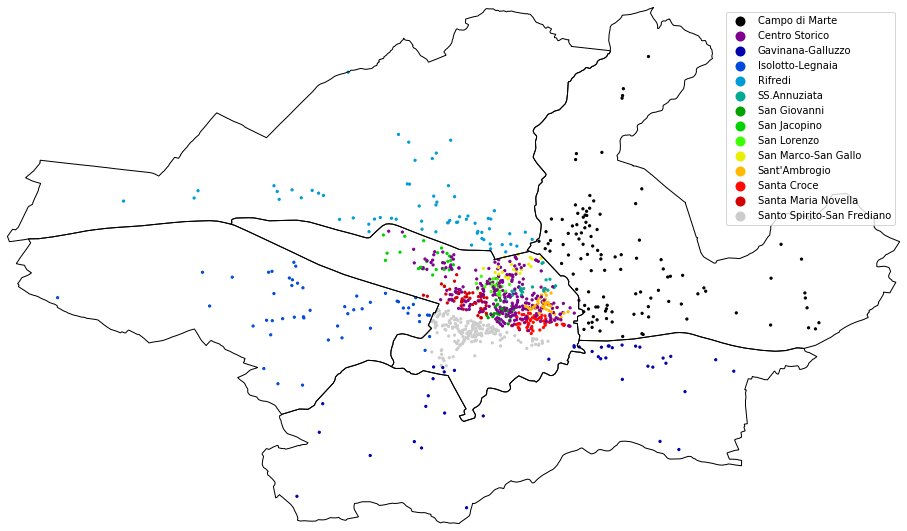

In [63]:
figsize=(16,16)
ax = geoplot.pointplot(
    gdf_lst.sample(1000),
    hue='neighbourhood',
    k=5,
    legend=True,
    cmap='nipy_spectral',
    figsize=figsize)
geoplot.polyplot(df_dst, ax=ax, zorder=1,figsize=figsize);

### Data consistency

Ouch! It looks like that the city centre `Centro Storico` is an umbrella term, but there are actually sub-districts which might be useful when deciding to where buy a flat. So, we have around the city centre:

* Centro Storico
    * San Giovanni
    * San Lorenzo
    * San Marco-San Gallo
    * San Jacopino
    * Sant'Ambrogio
    * Santa Croce
    * Santa Maria Novella
    * SS.Annunziata
* Santo Spirito-San Frediano

Whereas the suburb districs are:
* Campo di Marte
* Gavinana-Galluzzo
* Isolotto/Legnaia
* Rifredi

So we first want to replace `Centro Storico` with the closest cluster of sub-district. We can run a cluster analysis and re-assign the sub-district. But before doing that, let's check that the amount of data occurring within this are is a sensible parte of the dataset, as well as add information about prices.

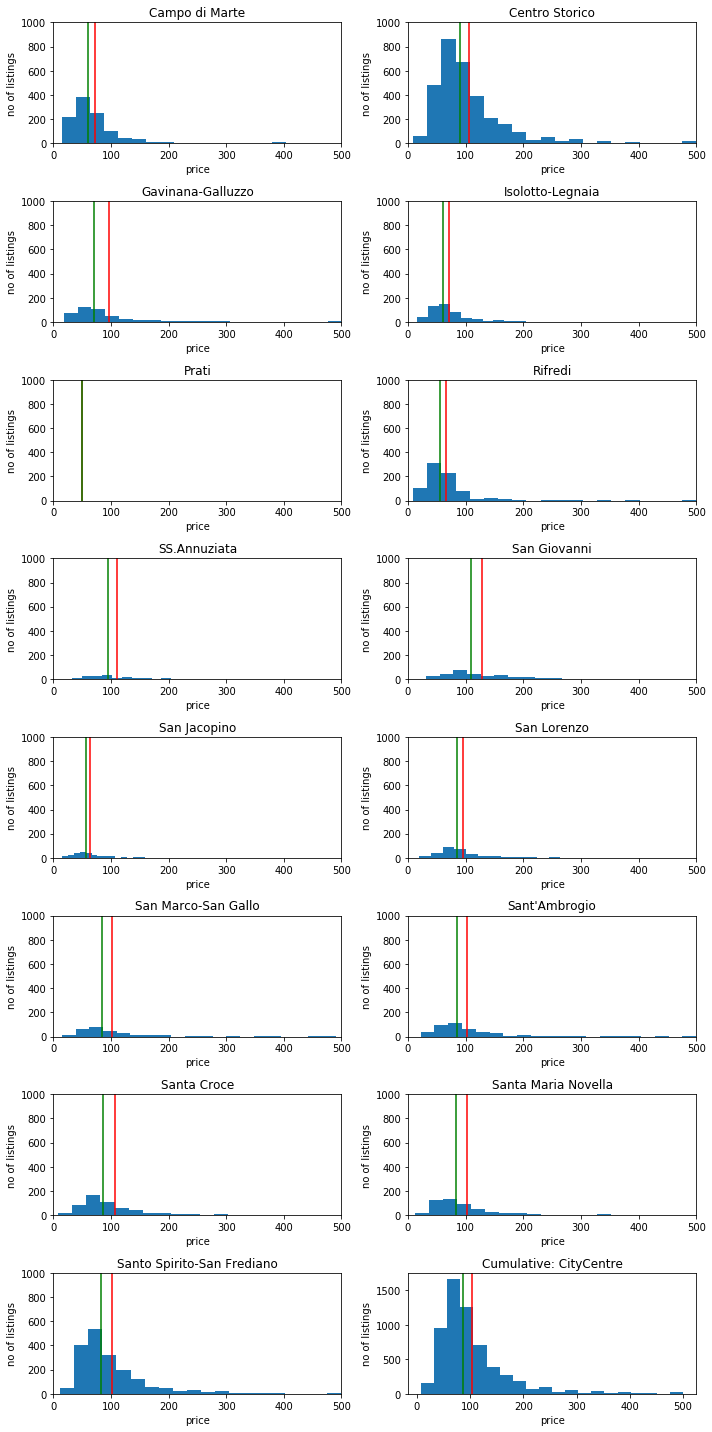

In [83]:
nb_gs = df_lst_.groupby('neighbourhood')
# print(len(nb_gs))
fig,axs = plt.subplots(8,2,figsize=(10,20))

cum_cs = []
avails = {}

for i,(n,g) in enumerate(nb_gs):
    ax = axs[i//2][i%2]
    ax.hist(g['price'], bins=20)
    if n in ['Centro Storico','San Giovanni','San Lorenzo','San Marco-San Gallo','San Jacopino','Sant\'Ambrogio','Santa Croce','Santa Maria Novella','SS.Annuziata']:
        cum_cs += list(g['price'].values)
    mn=g['price'].mean()
    md=g['price'].median()
    occ_365 = g['availability_365'].mean()
    avails['n'] = occ_365
    ax.axvline(x=mn,ymin=0,ymax=1000,color='red')
    ax.axvline(x=md,ymin=0,ymax=1000,color='green')
#     ax.hist(g['price'], bins=20, density=True)
    ax.set_xlabel('price')
    ax.set_ylabel('no of listings')
    ax.set_xlim((0,500))
    ax.set_ylim((0,1000))
    ax.title.set_text(n)# + ' - Avail_year: ' + str(int(round(occ_365))))

# cumulative
ax = axs[-1][-1]
ax.hist(cum_cs, bins=20)
ax.axvline(x=np.array(cum_cs).mean(),ymin=0,ymax=1000,color='red')
ax.axvline(x=np.median(np.array(cum_cs)),ymin=0,ymax=1000,color='green')
ax.set_xlabel('price')
ax.set_ylabel('no of listings')
ax.title.set_text('Cumulative: CityCentre')

plt.tight_layout()
plt.show()

In [89]:
tot_cc = len(cum_cs) + len(nb_gs.get_group('Santo Spirito-San Frediano'))
print('Percentage of listings in city centre: {:.1f}\nPercentage of central listings: {:.1f}'.format(100*len(cum_cs)/len(df_lst_), 100*tot_cc/len(df_lst_)))

Percentage of listings in city centre: 56.0
Percentage of central listings: 73.4


The city centre accounts for more than half of the listings, and if we account also the area on the other side of the river, but still central (Santo Spirito-San Frediano) we get to 76% of the listings. Quite an important part!

Ok, let's jump into the clustering and see if that fits our purpose.

In [46]:
# calculate walking distance to cathedral Santa Maria del Fiore
smdf = (11.255612,43.77313)
gdf_lst['dist_to_smdf'] = gdf_lst['geometry'].apply(lambda pt:round(geodesic(smdf,[pt.x,pt.y]).meters))

Let's do some data processing. Check nans, categorical features and create dummy ones if practicable.

In [47]:
gdf_lst

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,neighbourhood,neighbourhood_cleansed,latitude,...,number_of_reviews,number_of_reviews_ltm,since_first_review,since_last_review,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,geometry,dist_to_smdf
0,24469,99178,3375,within a few hours,1.00,f,5.0,Centro Storico,Centro Storico,43.78308,...,0,0,NaN,NaN,NaN,t,moderate_new,NaN,POINT (11.24418 43.78308),1667
1,24470,99178,3375,within a few hours,1.00,f,5.0,San Jacopino,Centro Storico,43.78287,...,3,1,3195.0,62.0,93.0,t,moderate_new,0.03,POINT (11.24431 43.78287),1641
2,24471,99178,3375,within a few hours,1.00,f,5.0,San Jacopino,Centro Storico,43.78292,...,0,0,NaN,NaN,NaN,t,moderate_new,NaN,POINT (11.2446 43.78292),1621
3,24472,99178,3375,within a few hours,1.00,f,5.0,San Jacopino,Centro Storico,43.78150,...,2,0,2916.0,2628.0,60.0,t,moderate_new,0.02,POINT (11.24507 43.7815),1482
4,24807,68490,3453,within an hour,1.00,f,2.0,Campo di Marte,Campo di Marte,43.77813,...,344,20,3329.0,32.0,96.0,t,moderate_new,3.10,POINT (11.29202 43.77813),4064
5,26738,113883,3344,within a few hours,1.00,f,2.0,Centro Storico,Centro Storico,43.77198,...,30,2,3235.0,17.0,90.0,f,strict_new,0.28,POINT (11.25695 43.77198),194
6,29982,129216,3319,within an hour,1.00,f,17.0,Centro Storico,Centro Storico,43.77450,...,24,6,2384.0,60.0,99.0,t,strict_new,0.30,POINT (11.25396 43.7745),236
7,31840,136927,3307,within an hour,0.96,f,7.0,Centro Storico,Centro Storico,43.77788,...,112,22,3286.0,70.0,93.0,t,moderate_new,1.02,POINT (11.25108 43.77788),721
8,32120,99235,3375,within an hour,1.00,f,1.0,Gavinana-Galluzzo,Gavinana Galluzzo,43.76352,...,15,1,3191.0,55.0,100.0,f,flexible_new,0.14,POINT (11.27726 43.76352),2614
9,32180,13925330,1904,within an hour,1.00,f,2.0,Santo Spirito-San Frediano,Centro Storico,43.76964,...,14,5,3292.0,136.0,94.0,t,strict_new,0.13,POINT (11.2436 43.76964),1382


In [48]:
gdf_lst['dist_to_smdf']

0        1667
1        1641
2        1621
3        1482
4        4064
         ... 
12009    1316
12018    2880
12019    2543
12020    1730
12021    2484
Name: dist_to_smdf, Length: 10694, dtype: int64

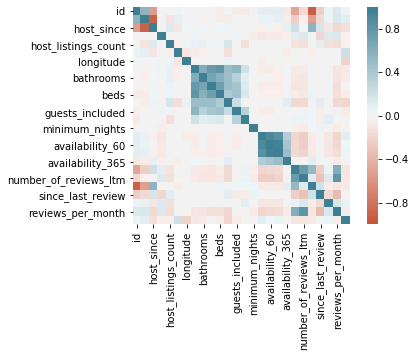

In [49]:
sns.heatmap(
    gdf_lst.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
);

### Listing Types

The `room_type` feature suggests that some hosts rent the place where they live, or might turn a property into a bnb-like business. The first case does not interest our research, whereas the latter poses serious problems in understanding how different rooms are part of the same flat (they would belong to the same host, but this might be a strong assumption to make).

In [50]:
# types of listing
df_lst_.groupby('room_type')['id'].nunique()

room_type
Entire home/apt    8503
Private room       2140
Shared room          51
Name: id, dtype: int64

In [51]:
one_shared_room = df_lst_[df_lst_['room_type']=='Private room'].groupby('host_id').count()==1
l = df_lst_.groupby('room_type')['id'].nunique()['Private room']
print('The provate rooms which are the only listing advertised by an host are the', 
      round((float(one_shared_room['id'].count())/l),4)*100,
      '%'
     )

The provate rooms which are the only listing advertised by an host are the 52.239999999999995 %


We can keep exploring the dataset keeping only `Entire home/apt`, which is more likely to answer our question

In [52]:
df_lst_ = df_lst_[df_lst_['room_type']=='Entire home/apt']
df_lst_.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,neighbourhood,neighbourhood_cleansed,latitude,...,availability_365,number_of_reviews,number_of_reviews_ltm,since_first_review,since_last_review,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,geometry
0,24469,99178,3375,within a few hours,1.0,f,5.0,Centro Storico,Centro Storico,43.78308,...,345,0,0,NaN,NaN,NaN,t,moderate_new,NaN,POINT (11.24418 43.78308)
1,24470,99178,3375,within a few hours,1.0,f,5.0,San Jacopino,Centro Storico,43.78287,...,350,3,1,3195.0,62.0,93.0,t,moderate_new,0.03,POINT (11.24431 43.78287)
2,24471,99178,3375,within a few hours,1.0,f,5.0,San Jacopino,Centro Storico,43.78292,...,355,0,0,NaN,NaN,NaN,t,moderate_new,NaN,POINT (11.2446 43.78292)
3,24472,99178,3375,within a few hours,1.0,f,5.0,San Jacopino,Centro Storico,43.78150,...,342,2,0,2916.0,2628.0,60.0,t,moderate_new,0.02,POINT (11.24507 43.7815)
4,24807,68490,3453,within an hour,1.0,f,2.0,Campo di Marte,Campo di Marte,43.77813,...,152,344,20,3329.0,32.0,96.0,t,moderate_new,3.10,POINT (11.29202 43.77813)


In [53]:
df_lst_.shape

(8503, 36)

#### Datetime variables

Here we want to handle date-time features byt referring to duration (days) until today. We assume today to be the last review date + 1.


In [24]:
# datetime
df_lst_ = df_kernel1.copy()
today = df_lst_.last_review.max()
print('last review:\t',today)
today += timedelta(days=1)
print('today:\t\t',today)

last review:	 2019-06-21 00:00:00
today:		 2019-06-22 00:00:00


In [25]:
dt_feats = df_lst_.select_dtypes(include=['datetime']).columns
dt_feats

Index(['host_since', 'first_review', 'last_review'], dtype='object')

In [26]:
f = lambda col:(today - col).dt.days

tmp_df = df_lst_[dt_feats].apply(f)
for col in dt_feats:
    df_lst_[col] = tmp_df[col]
#     df_lst_[col] = df_lst_[col].astype('int64')
df_lst_.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,neighbourhood,neighbourhood_cleansed,latitude,...,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,24469,99178,3375,within a few hours,100%,f,5.0,Centro Storico,Centro Storico,43.78308,...,70,345,0,0,NaN,NaN,NaN,t,moderate_new,NaN
1,24470,99178,3375,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78287,...,78,350,3,1,3195.0,62.0,93.0,t,moderate_new,0.03
2,24471,99178,3375,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78292,...,80,355,0,0,NaN,NaN,NaN,t,moderate_new,NaN
3,24472,99178,3375,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78150,...,67,342,2,0,2916.0,2628.0,60.0,t,moderate_new,0.02
4,24807,68490,3453,within an hour,100%,f,2.0,Campo di Marte,Campo di Marte,43.77813,...,36,152,344,20,3329.0,32.0,96.0,t,moderate_new,3.10


In [27]:
rn = {'host_since':'host_since','first_review':'since_first_review','last_review':'since_last_review'}
df_lst_.rename(columns=rn, inplace=True)
df_lst_.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,neighbourhood,neighbourhood_cleansed,latitude,...,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,since_first_review,since_last_review,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,24469,99178,3375,within a few hours,100%,f,5.0,Centro Storico,Centro Storico,43.78308,...,70,345,0,0,NaN,NaN,NaN,t,moderate_new,NaN
1,24470,99178,3375,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78287,...,78,350,3,1,3195.0,62.0,93.0,t,moderate_new,0.03
2,24471,99178,3375,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78292,...,80,355,0,0,NaN,NaN,NaN,t,moderate_new,NaN
3,24472,99178,3375,within a few hours,100%,f,5.0,San Jacopino,Centro Storico,43.78150,...,67,342,2,0,2916.0,2628.0,60.0,t,moderate_new,0.02
4,24807,68490,3453,within an hour,100%,f,2.0,Campo di Marte,Campo di Marte,43.77813,...,36,152,344,20,3329.0,32.0,96.0,t,moderate_new,3.10


In [28]:
df_lst_.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_listings_count',
       'neighbourhood', 'neighbourhood_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'extra_people', 'minimum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'since_first_review', 'since_last_review',
       'review_scores_rating', 'instant_bookable', 'cancellation_policy',
       'reviews_per_month'],
      dtype='object')

#### Categorical features

Then, transform the categorical variables into dummy ones


In [29]:
cat_df = df_lst_.select_dtypes(include=['object'])
cat_df.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type',
       'bed_type', 'amenities', 'instant_bookable', 'cancellation_policy'],
      dtype='object')

In [30]:
cat_df.head()

,host_response_time,host_response_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,property_type,room_type,bed_type,amenities,instant_bookable,cancellation_policy
0,within a few hours,100%,f,Centro Storico,Centro Storico,Apartment,Entire home/apt,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",t,moderate_new
1,within a few hours,100%,f,San Jacopino,Centro Storico,Apartment,Entire home/apt,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",t,moderate_new
2,within a few hours,100%,f,San Jacopino,Centro Storico,Apartment,Entire home/apt,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",t,moderate_new
3,within a few hours,100%,f,San Jacopino,Centro Storico,Apartment,Entire home/apt,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",t,moderate_new
4,within an hour,100%,f,Campo di Marte,Campo di Marte,Apartment,Entire home/apt,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",t,moderate_new


In [31]:
# check nan values
cat_df.isna().sum()

host_response_time        0
host_response_rate        0
host_is_superhost         0
neighbourhood             0
neighbourhood_cleansed    0
property_type             0
room_type                 0
bed_type                  0
amenities                 0
instant_bookable          0
cancellation_policy       0
dtype: int64

So, here we need a bit of work-arounds: 
  * `host_response_time` has some nans. This might be due to the fact that no bookings have been done for that listing. This should let us ask if we want to consider or not those (new listings? oldl istings fogotten by the host?). Let's drop them since we are talking about 10% of the dataset.
  * `host_response_rate` should be a float 0.0<f<1.0. 
  * `amenities` should be expanded properly as a series of dummy variables
  * `host_response_time` should be a numeric value as one hour is less than a few hours, and less than a day

In [32]:
df_lst_['host_response_rate'] = df_lst_['host_response_rate'].replace('[\%]','',regex=True).astype(float) * 0.01
cat_df = cat_df.drop(columns=['host_response_rate'], axis=1) #not in cat anymore
df_lst_['host_response_rate'].min(), df_lst_['host_response_rate'].max()

(0.0, 1.0)

In [33]:
cat_df['amenities'] = cat_df['amenities'].str.replace('["{}]',repl='',regex=True)
cat_df['amenities']

0        TV,Internet,Wifi,Air conditioning,Kitchen,Heat...
1        TV,Internet,Wifi,Air conditioning,Kitchen,Smok...
2        TV,Internet,Wifi,Air conditioning,Kitchen,Heat...
3        TV,Internet,Wifi,Air conditioning,Kitchen,Smok...
4        TV,Internet,Wifi,Air conditioning,Kitchen,Free...
                               ...                        
12009    TV,Wifi,Kitchen,Washer,Essentials,Lock on bedr...
12018    TV,Wifi,Air conditioning,Kitchen,Pets allowed,...
12019    TV,Wifi,Air conditioning,Kitchen,Smoking allow...
12020    Wifi,Kitchen,Elevator,Heating,Smoke detector,C...
12021    TV,Wifi,Air conditioning,Kitchen,Smoking allow...
Name: amenities, Length: 10694, dtype: object

In [34]:
amenities_len = cat_df['amenities'].map(lambda x: len(x))
ii, ll = amenities_len.idxmax(),amenities_len.max()
unique_amenities = cat_df['amenities'][ii].split(',')
unique_amenities

['TV',
 'Cable TV',
 'Internet',
 'Wifi',
 'Air conditioning',
 'Kitchen',
 'Paid parking off premises',
 'Elevator',
 'Heating',
 'Family/kid friendly',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Carbon monoxide detector',
 'Safety card',
 'Essentials',
 'Shampoo',
 'Lock on bedroom door',
 '24-hour check-in',
 'Hangers',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'Self check-in',
 'Keypad',
 'Private entrance',
 'Bathtub',
 'Baby bath',
 'Changing table',
 'High chair',
 'Stair gates',
 'Window guards',
 'Crib',
 'Pack ’n Play/travel crib',
 'Room-darkening shades',
 'Hot water',
 'Body soap',
 'Bath towel',
 'Toilet paper',
 'Bed linens',
 'Extra pillows and blankets',
 'Ethernet connection',
 'Pocket wifi',
 'Microwave',
 'Coffee maker',
 'Refrigerator',
 'Dishes and silverware',
 'Cooking basics',
 'Stove',
 'Single level home',
 'Patio or balcony',
 'Garden or backyard',
 'Luggage dropoff allowed',
 'Long term stays allowed',
 'Wide hallways',
 'No stairs or steps to e

In [35]:
# dummies for amenities => expand strings
am_df = pd.DataFrame()
for a in unique_amenities:
    name = 'amenities_' + a.replace(' ','_')
    am_df[name] = cat_df['amenities'].str.contains(a)
    am_df[name] = am_df[name].astype('float64')
am_df.head()

,amenities_TV,amenities_Cable_TV,amenities_Internet,amenities_Wifi,amenities_Air_conditioning,amenities_Kitchen,amenities_Paid_parking_off_premises,amenities_Elevator,amenities_Heating,amenities_Family/kid_friendly,...,amenities_Netflix,amenities_Standing_valet,amenities_Pillow-top_mattress,amenities_Memory_foam_mattress,amenities_En_suite_bathroom,amenities_Walk-in_shower,amenities_Mudroom,amenities_Full_kitchen,amenities_Bedroom_comforts,amenities_Bathroom_essentials
0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# dummies for other cat features
cat_df = cat_df.drop(columns=['amenities'], axis=1).copy() # not useful anymore
cat_df_ = cat_df.copy()
for col in cat_df:
    print('\nProcessing columns:',col)
    # there are no nans in the df
    expanded = pd.get_dummies(cat_df_[col], dummy_na=False, prefix=col)
    print('Column {} expanded into {}'.format(col, expanded.columns))
    cat_df_ = pd.concat([cat_df_.drop(columns=[col], axis=1), expanded], axis=1)

cat_df_.head()


Processing columns: host_response_time
Column host_response_time expanded into Index(['host_response_time_a few days or more',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour'],
      dtype='object')

Processing columns: host_is_superhost
Column host_is_superhost expanded into Index(['host_is_superhost_f', 'host_is_superhost_t'], dtype='object')

Processing columns: neighbourhood
Column neighbourhood expanded into Index(['neighbourhood_Campo di Marte', 'neighbourhood_Centro Storico',
       'neighbourhood_Gavinana-Galluzzo', 'neighbourhood_Isolotto-Legnaia',
       'neighbourhood_Prati', 'neighbourhood_Rifredi',
       'neighbourhood_SS.Annuziata', 'neighbourhood_San Giovanni',
       'neighbourhood_San Jacopino', 'neighbourhood_San Lorenzo',
       'neighbourhood_San Marco-San Gallo', 'neighbourhood_Sant'Ambrogio',
       'neighbourhood_Santa Croce', 'neighbourhood_Santa Maria Novella',
       'neighb

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_f,host_is_superhost_t,neighbourhood_Campo di Marte,neighbourhood_Centro Storico,neighbourhood_Gavinana-Galluzzo,neighbourhood_Isolotto-Legnaia,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible_new,cancellation_policy_moderate_new,cancellation_policy_strict_new,cancellation_policy_super_strict_30_new,cancellation_policy_super_strict_60_new
0,0,0,1,0,1,0,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,1,0,1,0,0,0


In [37]:
kernel_cat = pd.concat([df_lst_.drop(columns=cat_df.columns, axis=1), am_df, cat_df_], axis=1)
kernel_cat.head()

,id,host_id,host_since,host_response_rate,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible_new,cancellation_policy_moderate_new,cancellation_policy_strict_new,cancellation_policy_super_strict_30_new,cancellation_policy_super_strict_60_new
0,24469,99178,3375,1.0,5.0,43.78308,11.24418,4,1.0,1.0,...,0,0,1,0,1,0,1,0,0,0
1,24470,99178,3375,1.0,5.0,43.78287,11.24431,3,1.0,1.0,...,0,0,1,0,1,0,1,0,0,0
2,24471,99178,3375,1.0,5.0,43.78292,11.24460,6,1.5,2.0,...,0,0,1,0,1,0,1,0,0,0
3,24472,99178,3375,1.0,5.0,43.78150,11.24507,6,1.0,2.0,...,0,0,1,0,1,0,1,0,0,0
4,24807,68490,3453,1.0,2.0,43.77813,11.29202,6,2.0,3.0,...,0,0,1,0,1,0,1,0,0,0


In [38]:
list(kernel_cat.columns)

['id',
 'host_id',
 'host_since',
 'host_response_rate',
 'host_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'since_first_review',
 'since_last_review',
 'review_scores_rating',
 'reviews_per_month',
 'amenities_TV',
 'amenities_Cable_TV',
 'amenities_Internet',
 'amenities_Wifi',
 'amenities_Air_conditioning',
 'amenities_Kitchen',
 'amenities_Paid_parking_off_premises',
 'amenities_Elevator',
 'amenities_Heating',
 'amenities_Family/kid_friendly',
 'amenities_Washer',
 'amenities_Dryer',
 'amenities_Smoke_detector',
 'amenities_Carbon_monoxide_detector',
 'amenities_Safety_card',
 'amenities_Essentials',
 'amenities_Shampoo',
 'amenities_Lock_on_bedroom_door',
 'amenities_24-hour_check-in',
 'amenities_Hangers',
 'amenities_Ha

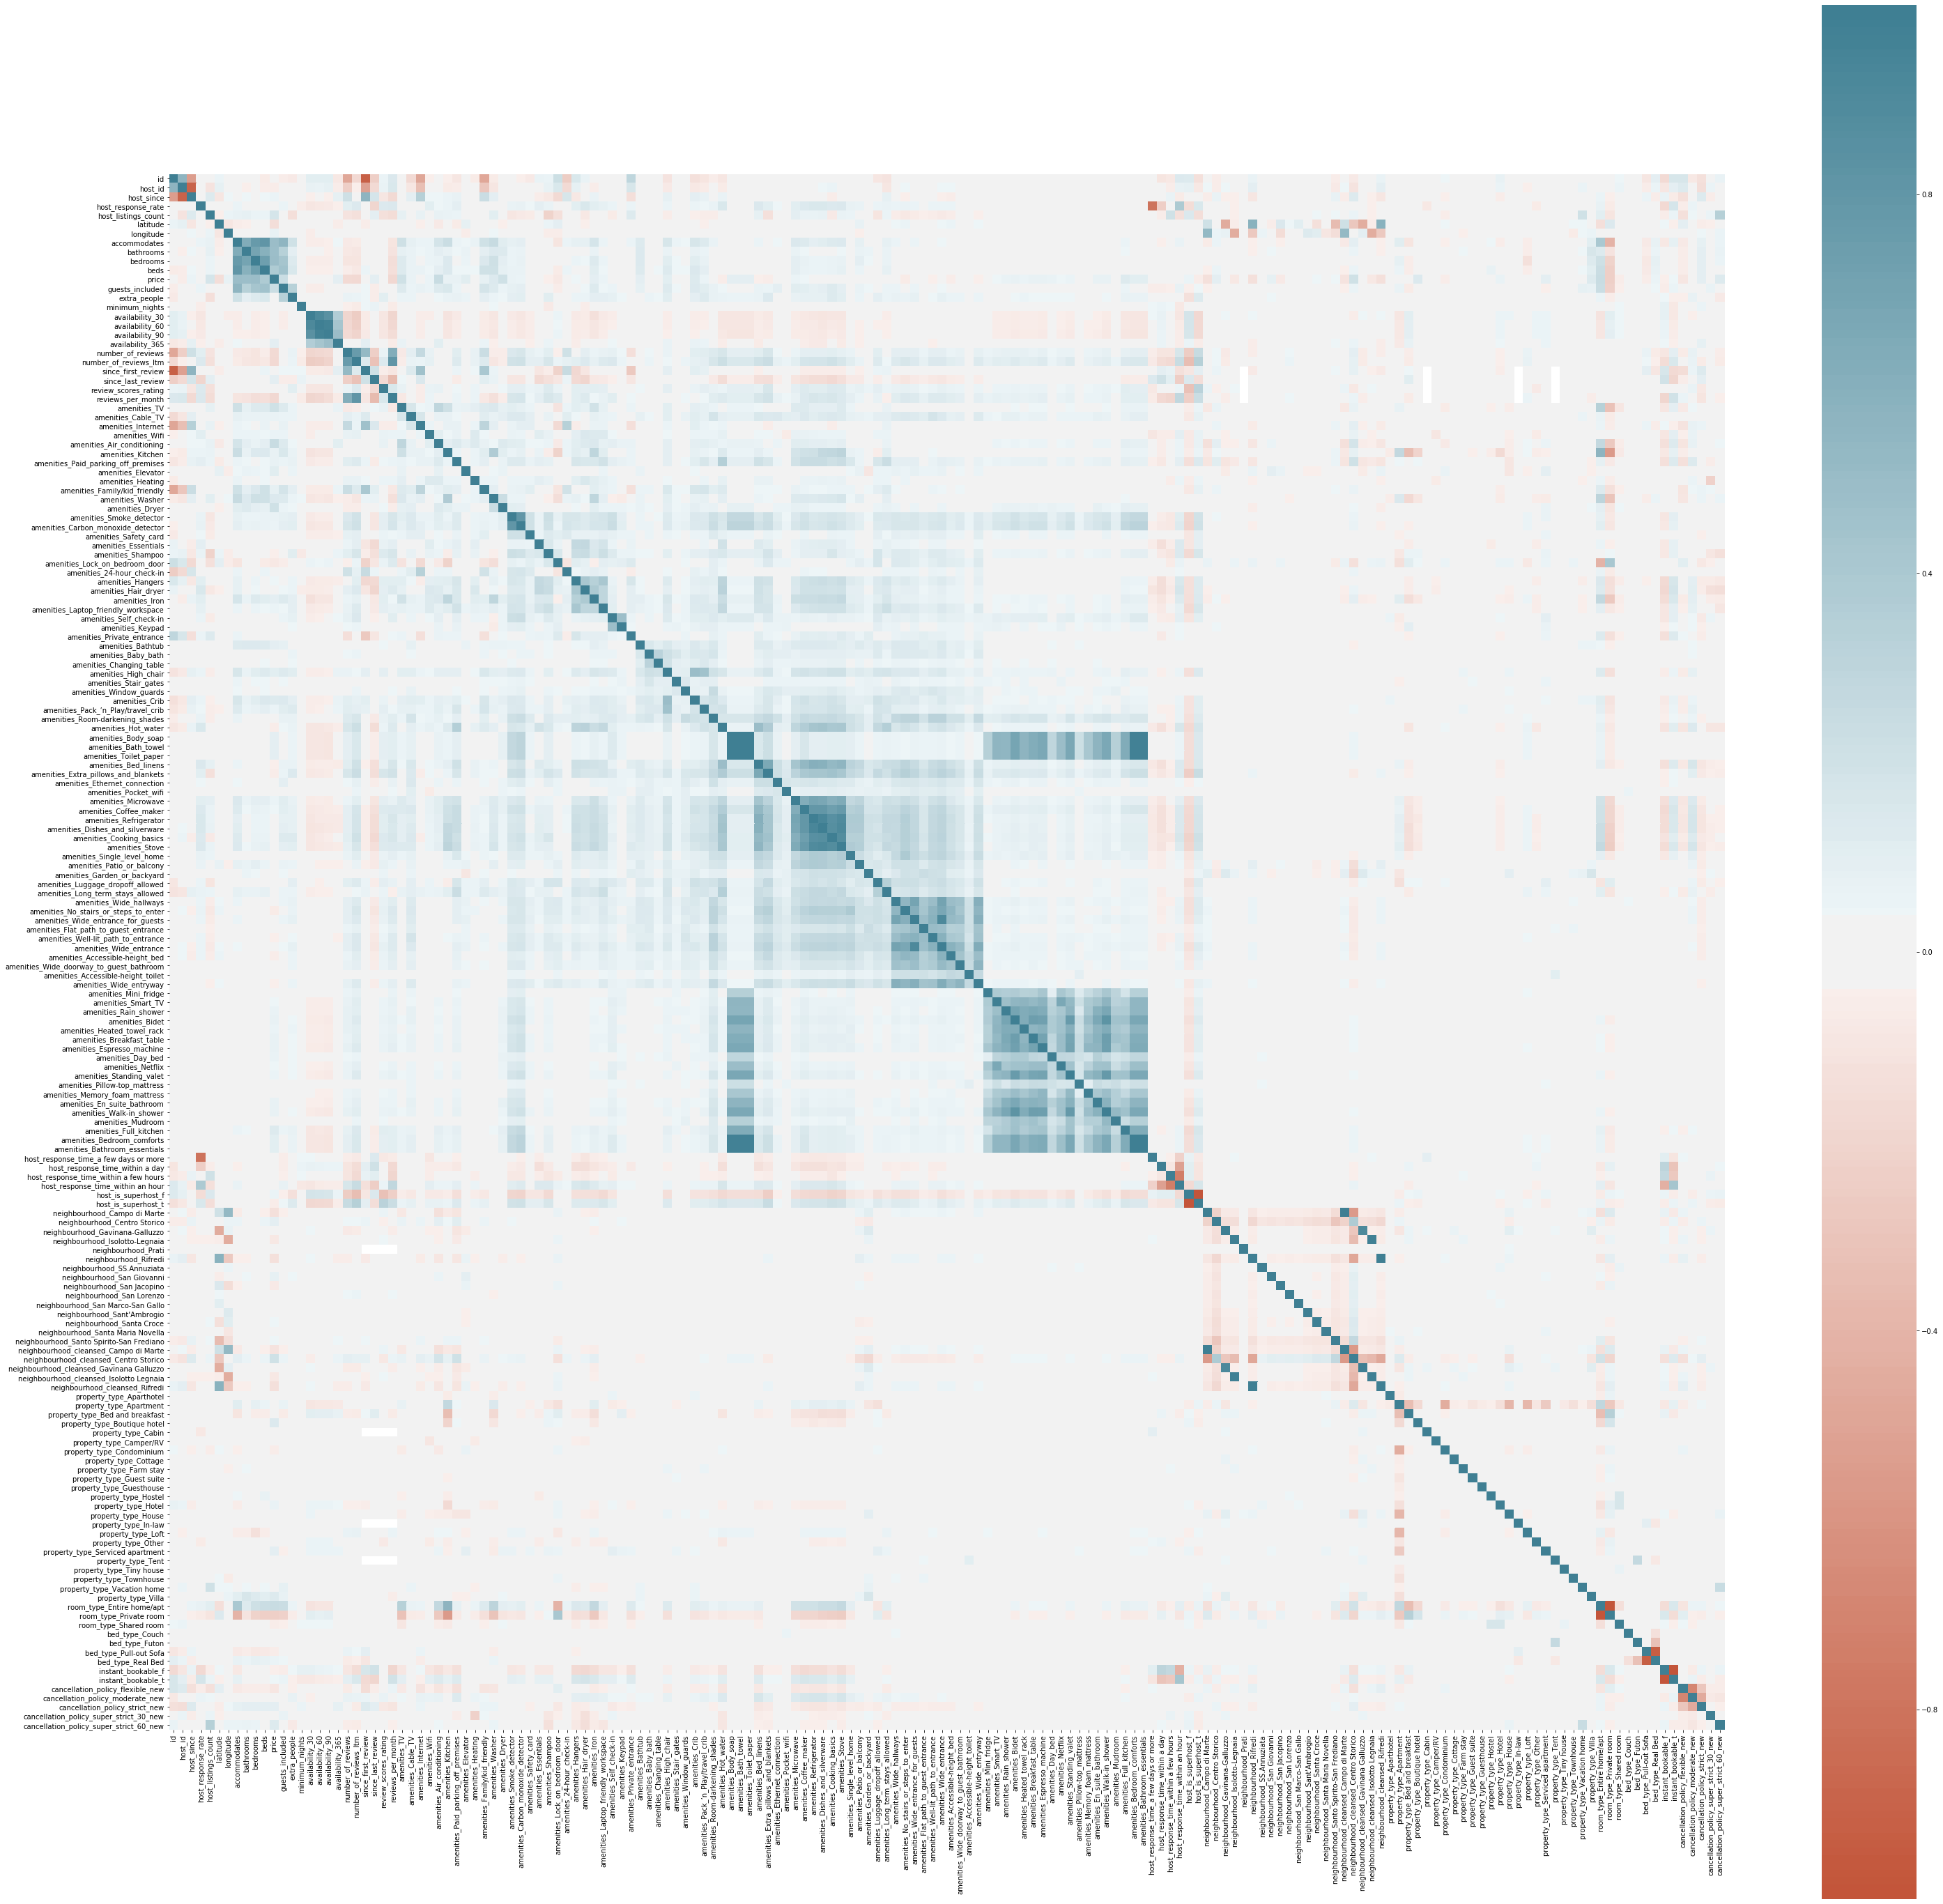

In [39]:
fig = plt.figure(figsize=(50,50))
sns.heatmap(
    kernel_cat.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
);